This notebook provides the code to apply the trained models in a specific health region 

In [1]:
import numpy as np 
import pandas as pd 
import preprocess_data as prep
import matplotlib.pyplot as plt
from keras.models import load_model
from models import make_predictions

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)


In [3]:
state_to_code = {'RJ': 33, 'ES': 32, 'PR': 41, 'CE': 23, 'MA': 21,
                 'MG': 31, 'SC': 42, 'PE': 26, 'PB': 25, 'RN': 24,
                 'PI': 22, 'AL': 27, 'SE': 28, 'SP': 35, 'RS': 43,
                 'PA': 15, 'AP': 16, 'RR': 14, 'RO': 11, 'AM': 13,
                 'AC': 12, 'MT': 51, 'MS': 50, 'GO': 52, 'TO': 17,
                 'DF': 53, 'BA': 29}


In [4]:
test_year = 2024
STATE = 'MG'
region = 31016
model_name = 'baseline'

### Model without clima: 

In [5]:
df_all = prep.load_cases_data()
enso = prep.load_sea_indicators()
df_pop_region = pd.read_csv('./data/pop_regional.csv')
df_all_epi = pd.read_csv('./data/episcanner_regional.csv.gz')

In [6]:
cols_to_norm = ['casos','epiweek', 'enso',  'R0', 'total_cases',
                          'peak_week', 'perc_geocode']

In [7]:
df = df_all.loc[df_all.uf == STATE]

In [8]:
list_of_enso_indicators = ['enso', 'iod', 'pdo']

indicators = [item for item in list_of_enso_indicators if item in cols_to_norm]
 
df_w = prep.aggregate_data(df, region, column = 'regional_geocode')

#df_w['inc'] = 10*df_w['casos']/df_pop_region.loc[df_pop_region.regional_geocode==geo]['pop'].values[0]
df_w['pop_norm'] = df_pop_region.loc[df_pop_region.regional_geocode==region]['pop_norm'].values[0]

df_w = df_w.reset_index().merge( df_all_epi.loc[df_all_epi.code_region == region][['year',
                                                          'R0', 
                                                          'peak_week',
                                                          'total_cases', 
                                                          'perc_geocode']], how = 'left', left_on = 'year', right_on = 'year').set_index('date')

df_w = df_w.fillna(0)
        
data = df_w.merge(enso[indicators], left_index = True, right_index = True)

X_train, y_train, norm_values = prep.get_train_data(data.loc[data.year < test_year], columns_to_normalize= cols_to_norm)

X_test, y_test =  prep.get_test_data(norm_values, data, test_year, columns_to_normalize = cols_to_norm, target_1 = False) 


In [9]:
dates = prep.gen_forecast_dates(test_year)
model = load_model(f'./saved_models/model_{STATE}_{test_year-1}_{model_name}.keras') 

df_preds = make_predictions(model, X_test, norm_values, dates = dates)

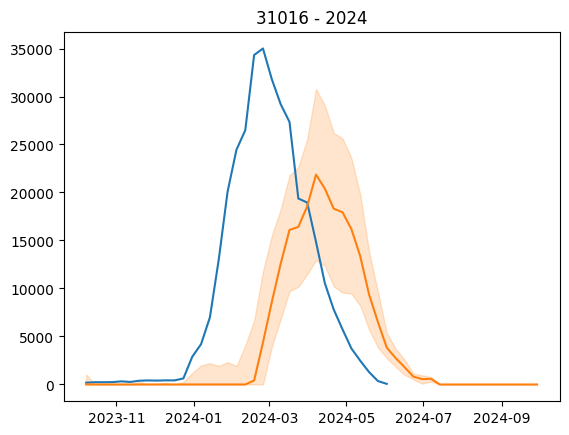

In [11]:
fig, ax = plt.subplots()

ax.plot(df_preds.dates[:35], y_test[0]*norm_values['casos'], label = 'Data')

ax.plot(df_preds.dates, df_preds.preds, label = 'preds')

ax.fill_between( df_preds.dates, df_preds.lower, df_preds.upper, color = 'tab:orange', alpha = 0.2)

ax.set_title(f'{region} - {test_year}')

plt.show()

### Model with clima: 

In [12]:
columns_to_normalize = ['casos', 'epiweek', 'temp_med', 'temp_amp', 'rel_humid_med', 'precip_tot', 'enso', 'iod', 'pdo',
                            'R0', 'total_cases',
                             'peak_week', 'perc_geocode']

list_of_enso_indicators = ['enso', 'iod', 'pdo']

indicators = [item for item in list_of_enso_indicators if item in columns_to_normalize]
 

In [13]:
df_clima_all = prep.load_climate_data()
df_clima = df_clima_all.loc[df_clima_all.geocode.astype(str).str[:2] == str(state_to_code[STATE])]

df_end = df.merge(df_clima, left_on = ['date', 'epiweek', 'geocode'], right_on = ['date', 'epiweek', 'geocode'])

df_end.date = pd.to_datetime(df_end.date)

df_end.set_index('date', inplace = True)

df_w = prep.aggregate_data_clima(df_end, region, column = 'regional_geocode')

#df_w['inc'] = 10*df_w['casos']/df_pop_region.loc[df_pop_region.regional_geocode==geo]['pop'].values[0]
df_w['pop_norm'] = df_pop_region.loc[df_pop_region.regional_geocode==region]['pop_norm'].values[0]

df_w = df_w.reset_index().merge( df_all_epi.loc[df_all_epi.code_region == region][['year',
                                                          'R0', 
                                                          'peak_week',
                                                          'total_cases', 
                                                          'perc_geocode']], how = 'left', left_on = 'year', right_on = 'year').set_index('date')

df_w = df_w.fillna(0)
        
data = df_w.merge(enso[indicators], left_index = True, right_index = True)

X_train, y_train, norm_values = prep.get_train_data(data.loc[data.year < test_year], columns_to_normalize= columns_to_normalize)

X_test, y_test =  prep.get_test_data(norm_values, data, test_year, columns_to_normalize = columns_to_normalize) 


In [14]:
X_test.shape

(1, 89, 14)

In [15]:
dates = prep.gen_forecast_dates(test_year)
model = load_model(f'./saved_models/model_climate_{STATE}_{test_year-1}_{model_name}.keras') 

df_preds = make_predictions(model, X_test, norm_values, dates = dates)

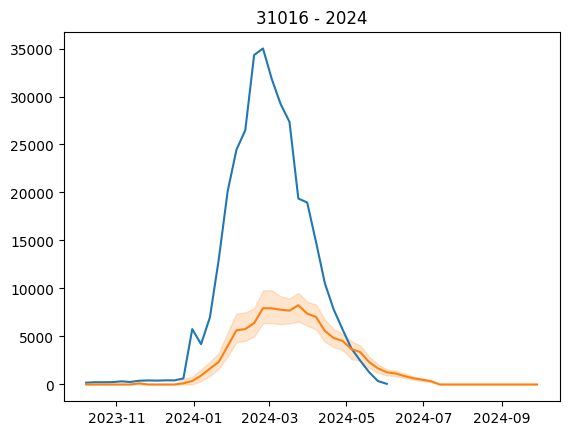

In [16]:
fig, ax = plt.subplots()

ax.plot(df_preds.dates[:35], y_test[0]*norm_values['casos'], label = 'Data')

ax.plot(df_preds.dates, df_preds.preds, label = 'preds')

ax.fill_between( df_preds.dates, df_preds.lower, df_preds.upper, color = 'tab:orange', alpha = 0.2)

ax.set_title(f'{region} - {test_year}')

plt.show()